In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [116]:
# For training (with Augmentation)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# For the test (without augmentation, just normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(root="../data", train=True, download=True, transform=train_transform)
test_data  = datasets.CIFAR10(root="../data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [117]:
class CNN_Base(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1) # (3, 32, 32) -> (64, 32, 32)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # (64, 32, 32) -> (64, 16, 16)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # (64, 16, 16) -> (128, 16, 16)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.1)
        # (128, 16, 16) -> (128, 8, 8)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) # (128, 8, 8) -> (256, 8, 8)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(0.1)
        # (256, 16, 16) -> (256, 4, 4)

        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1) # (256, 8, 8) -> (256, 8, 8)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout(0.1)
        # (256, 4, 4) -> (256, 4, 4)

        input_features_fc = 256 * 4 * 4
        self.fc = nn.Linear(input_features_fc, 10)
        self.dropout_fc = nn.Dropout(0.4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout4(x)
        
        # Flattening of the tensor for the FC layer
        x = x.view(x.size(0), -1)

        x = self.dropout_fc(x)
        
        return self.fc(x)

In [118]:
def train_model(model, dataloader, epochs=20):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    # Lists to store training metrics
    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        loop = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs} 🚀 Training", leave=False, colour="green")

        for x, y in loop:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(preds, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

            loop.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct/total:.4f}")

        avg_loss = total_loss / len(dataloader)
        avg_acc = correct / total
        train_losses.append(avg_loss)
        train_accs.append(avg_acc)

        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f} - LR: {current_lr:.6f}")

    return train_losses, train_accs

In [119]:
def evaluate(model, dataloader):
    model = model.to(device)
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct, total, total_loss = 0, 0, 0

    loop = tqdm(dataloader, desc="🧪 Evaluation", leave=False, colour="blue")

    with torch.no_grad():
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            total_loss += loss.item() * y.size(0)
            _, predicted = torch.max(preds, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
            loop.set_postfix(loss=f"{total_loss / total:.4f}", acc=f"{correct/total:.4f}")

    avg_loss = total_loss / total
    avg_acc = correct / total
    print(f"Evaluation - Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")

    return avg_loss, avg_acc

In [125]:
def plot_training_curves(train_losses, train_accs):
    plt.figure(figsize=(10, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color="blue", linewidth=2)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy", color="green", linewidth=2)
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

In [121]:
model = CNN_Base()
print(model)

CNN_Base(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=4096, out_features=10, bias=Tru

In [ ]:
train_losses, train_accs = train_model(model, train_loader, epochs=50)

Epoch 1/5 🚀 Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 1.5393, Accuracy: 0.4491 - LR: 0.001000


Epoch 2/5 - Loss: 1.1630, Accuracy: 0.5861 - LR: 0.001000


Epoch 3/5 - Loss: 0.9993, Accuracy: 0.6466 - LR: 0.001000


Epoch 4/5 - Loss: 0.8945, Accuracy: 0.6826 - LR: 0.001000


                                                                                                 s=0.8044]

Epoch 5/5 - Loss: 0.8198, Accuracy: 0.7121 - LR: 0.000500


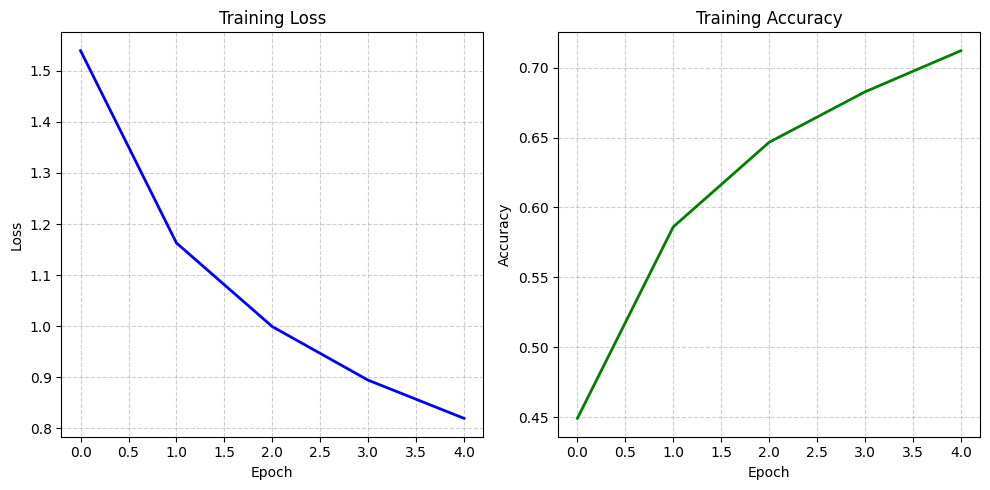

In [126]:
plot_training_curves(train_losses, train_accs)

In [127]:
evaluate(model, test_loader)

Evaluation - Loss: 0.7232, Accuracy: 0.7453


(0.7231588180541992, 0.7453)